# 데이터마이닝 5주차 실습
## 1. Classification Tree Pruning

+ CART
+ When Decision Tree grows completely without any constraints, it is overfitted to the training datasets
+ Pruning
    - cost complexity $CC(T) = Err(T)+\alpha\times L(T)$,  
    $Err(T)$ : proportion of misclassified records in the validation data,  
    $L(T)$ : the number of terminal nodes in tree T,  
    $\alpha$ : penalty factor attached to the tree size (set by user)  
    - scikit-learn uses the total sample weighted impurity of the terminal node for $Err(T)$

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# set figure params (figure size, font size)
plt.rc('figure', figsize=(10, 8))
plt.rc('font', size=13)

### 1.1 Dataset
+ iris plants dataset

In [2]:
# load dataset and configure dataframe
from sklearn.datasets import load_iris
iris=load_iris()
df_iris = pd.DataFrame(data=iris.data, 
                       columns= iris.feature_names)
df_iris['class'] = iris.target
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# randomly split into a training and test dataset
from sklearn.model_selection import train_test_split
X = df_iris.drop(columns='class')
y = df_iris['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

### 1.2 Penalty factor $\alpha$

In [4]:
# fitting a tree
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(ccp_alpha=0.03) # cost complexity alpha
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.03)

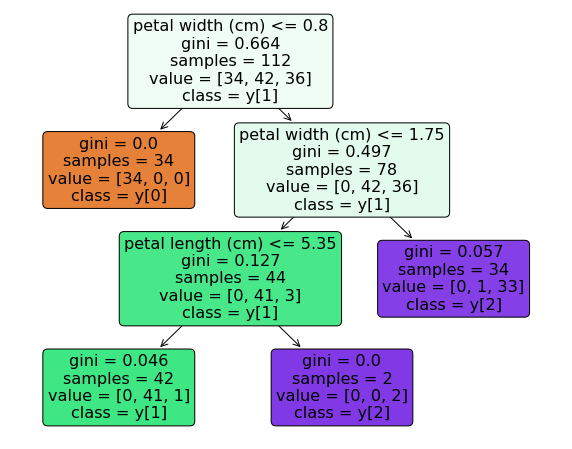

In [5]:
# plot tree
from sklearn import tree
tree.plot_tree(clf_tree,
               feature_names=X.columns, class_names=True,
               filled=True, rounded=True) 
plt.show()

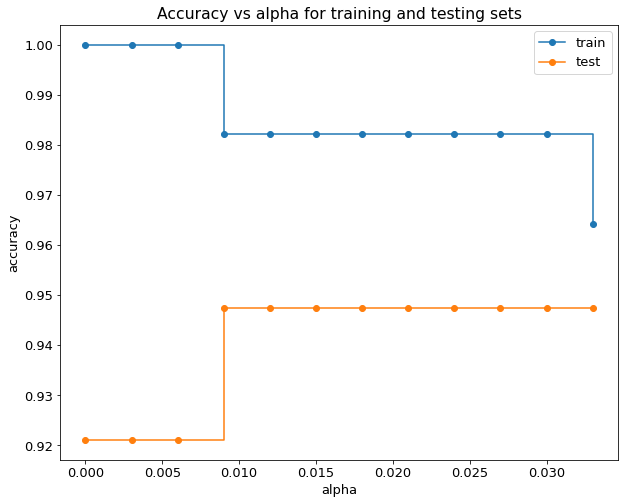

In [6]:
ccp_alphas= np.arange(0,0.036,0.003) #
clf_trees = []
for ccp_alpha in ccp_alphas:
    clf_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_tree.fit(X_train, y_train)
    clf_trees.append(clf_tree)

train_scores = [clf_tree.score(X_train, y_train) for clf_tree in clf_trees]
test_scores = [clf_tree.score(X_test, y_test) for clf_tree in clf_trees]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

## 2. Gain Ratio

+ C4.5
+ Entropy
    - $E(S) = - \sum^m_{k=1}p_k\log_2(p_k)$
    - $E\text{-}gain = E(S) - (\frac{|S_l|}{|S|}E(S_l)+\frac{|S_r|}{|S|}E(S_r))$
+ gain ratio
    - normalizing factor $N(S) = -(\frac{|S_{left}\,|}{|S|}\log_2\frac{|S_{left}\,|}{|S|}+\frac{|S_{right}\,|}{|S|}\log_2\frac{|S_{right}\,|}{|S|})$
    - entropy gain ratio = $\frac{E\text{-}gain}{N(S)}$
    - gini gain ratio = $\frac{G\text{-}gain}{N(S)}$
    - information gain ratio biases the decision tree against considering attributes with a large number of distinct values
    
### 2.1 Dataset

+ Titanic dataset
+ Columns
    - survived - Survival (0 = No; 1 = Yes)
    - pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
    - sex - Sex
    - age - Age
    - sibsp - Number of Siblings/Spouses Aboard
    - parch - Number of Parents/Children Aboard
    - fare - Passenger Fare
    - embarked - Port of Embarkation (C=Cherbourg, Q=Queenstown, S=Southampton)

In [7]:
# load dataset and configure dataframe
titanic = sns.load_dataset("titanic")
df_titanic = titanic[['pclass','sex','age','sibsp','parch','fare','embarked','survived']]
df_titanic.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [8]:
# check dataframe information
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   sex       891 non-null    object 
 2   age       714 non-null    float64
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   fare      891 non-null    float64
 6   embarked  889 non-null    object 
 7   survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [9]:
# handling missing values
df_titanic.dropna(axis=0, inplace=True)
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    712 non-null    int64  
 1   sex       712 non-null    object 
 2   age       712 non-null    float64
 3   sibsp     712 non-null    int64  
 4   parch     712 non-null    int64  
 5   fare      712 non-null    float64
 6   embarked  712 non-null    object 
 7   survived  712 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


C:\Users\user\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### 2.2 data exploration

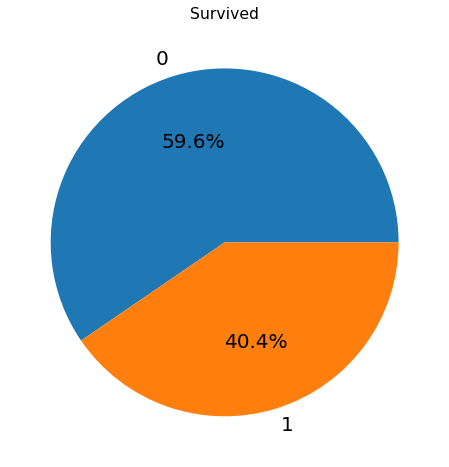

In [10]:
# pie chart
plt.pie(df_titanic['survived'].value_counts(), 
        labels=[0,1],
        autopct='%1.1f%%', 
        textprops={'fontsize': 20})
plt.title('Survived')
plt.show()

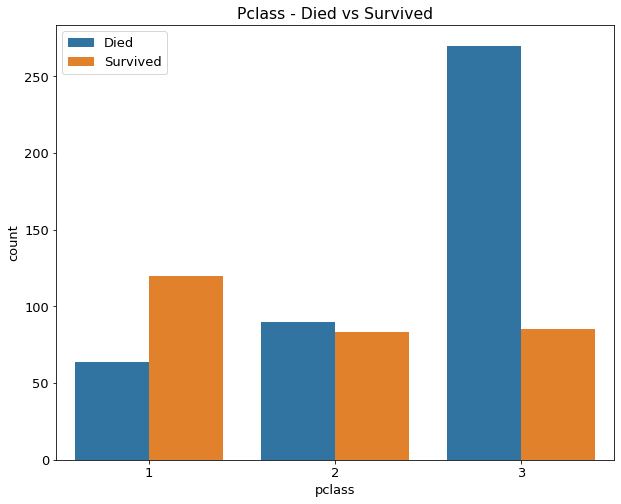

In [11]:
# count chart
sns.countplot(x='pclass', hue='survived', data=df_titanic)
plt.title('Pclass - Died vs Survived')
plt.legend(['Died','Survived'])
plt.show()

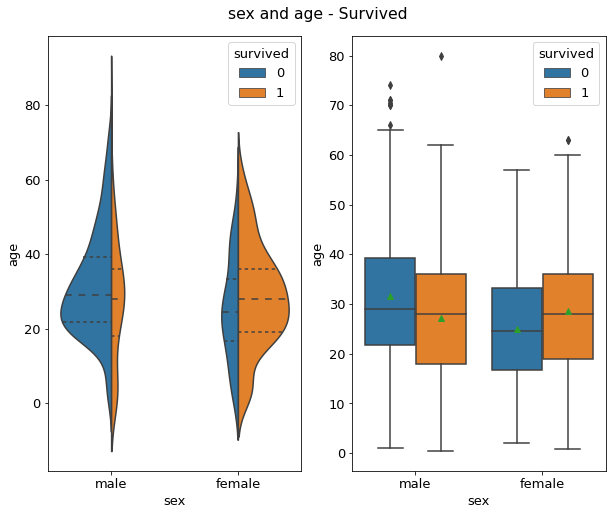

In [12]:
# violinplot, box plot
f1 = 'sex'
f2 = 'age'
fig, ax = plt.subplots(1, 2)
sns.violinplot(x=f1, y=f2, hue='survived', data=df_titanic,
               scale='count', split=True, inner="quartile", 
               ax=ax[0])
sns.boxplot(x=f1, y=f2, hue='survived', data=df_titanic, 
            showmeans=True, 
            ax=ax[1])
plt.suptitle('{} and {} - Survived'.format(f1,f2), y=0.93)
plt.show()

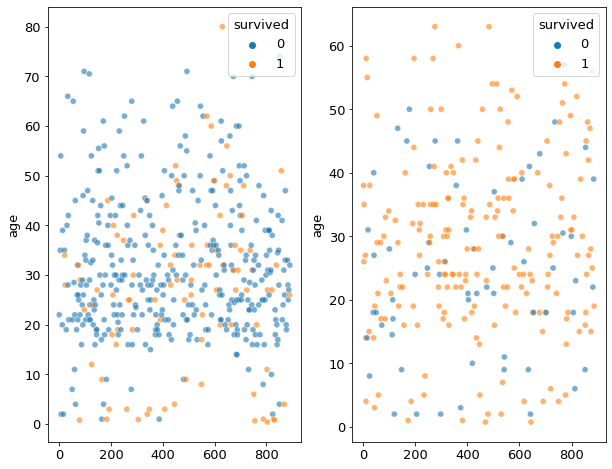

In [13]:
# scatterplot & colormapping
male=df_titanic[df_titanic['sex']=='male']
female=df_titanic[df_titanic['sex']=='female']

f1='age'
fig, ax = plt.subplots(1, 2)
sns.scatterplot(x=male.index, y=f1, data=male,
               hue='survived', alpha=0.6, ax=ax[0])
sns.scatterplot(x=female.index, y=f1, data=female,
               hue='survived', alpha=0.6, ax=ax[1])
plt.show()

In [14]:
# randomly split into a training and test dataset
from sklearn.model_selection import train_test_split
target_name = 'survived'
X = df_titanic.drop(columns=target_name).copy()
y = df_titanic[target_name].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Concatenating X,y -> training dataset([X_train,y_train]), test dataset([X_test,y_test]) 
train_idx, test_idx = X_train.index, X_test.index
df_train, df_test = df_titanic.loc[train_idx,:], df_titanic.loc[test_idx,:]
df_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
867,1,male,31.0,0,0,50.4958,S,0
332,1,male,38.0,0,1,153.4625,S,0
20,2,male,35.0,0,0,26.0000,S,0
606,3,male,30.0,0,0,7.8958,S,0
379,3,male,19.0,0,0,7.7750,S,0


In [15]:
df_train.nunique()

pclass        3
sex           2
age          82
sibsp         6
parch         7
fare        195
embarked      3
survived      2
dtype: int64

### 2.2 Model
+ entropy, gini, gini_GR, entropy_GR 

In [16]:
# Use these python files to find entropy gain_ratio(/modules/.)
from modules.usertree import userTree as utr
import modules.utils as utils

In [17]:
# our program
## params: entropy, gini, entropy_GR 
clf = utr(max_depth=4, min_samples=0.01*len(df_train), 
          params ='entropy_GR')

In [18]:
# fitting a tree
target_name = 'survived' # target_attribute_name: 목표변수(y) 컬럼명
clf.fit(df_train, target_attribute_name = target_name)

### 2.3 Visualizations

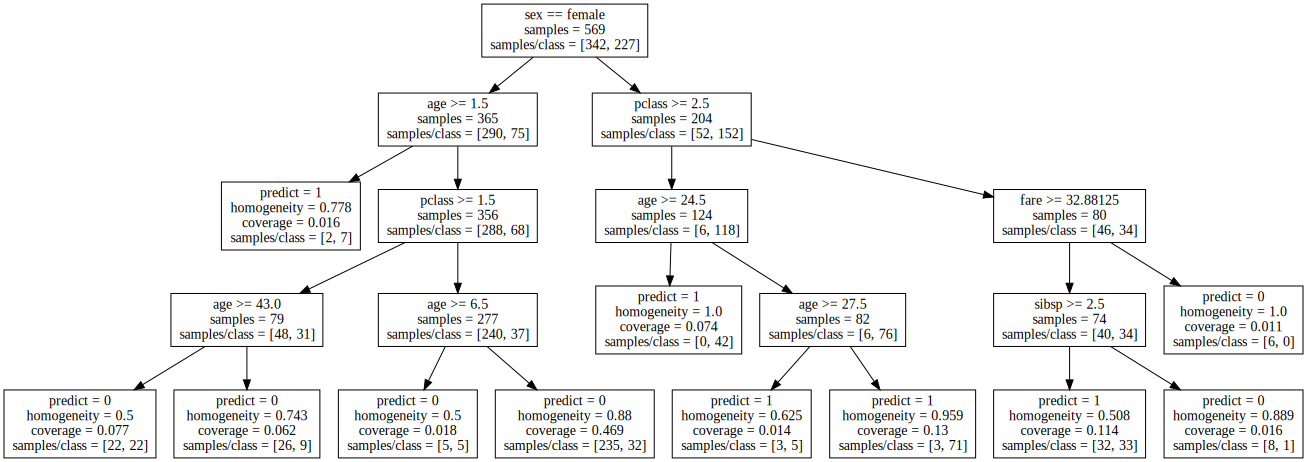

In [19]:
# plot tree
# (주의) 왼쪽이 False, 오른쪽이 True임
import graphviz
graph_dir = 'graph'
node, edge = clf.graph.tree_to_graph(clf.graph_tree)
tree_graph = graphviz.Source(node + edge+'\n}')
tree_graph # (주의) 왼쪽이 False, 오른쪽이 True임. sklearn과 반대임.

## (주의) 왼쪽이 False, 오른쪽이 True임. sklearn과 반대임.

In [23]:
# exprort graph as pdf
graph_dir = 'graph'
dset_name = 'Titanic'
tree_graph.render('tree_GR_{}'.format(dset_name))

'tree_GR_Titanic.pdf'

### 2.4 Predictive performance
+ accuracy

In [24]:
# predictive performance using our modules
pred_y, prob_ = clf.predict(df_train, clf.tree)

scores = utils.perform_check(df_train[target_name],
         pred_y, prob_,
         len(clf.CLASS_DICT_), clf.CLASS_DICT_)
scores[0] # accuracy

0.8084358523725835

In [25]:
# using scikit-learn
from sklearn.metrics import accuracy_score
accuracy_score(df_train[target_name], pred_y.values.ravel().astype(int))

0.8084358523725835